In [1]:
# 2021 / 07 / 07. Dongil Choi
# Reference --> https://notebook.community/aerospace-notebook/aerospace-notebook/Segway-control

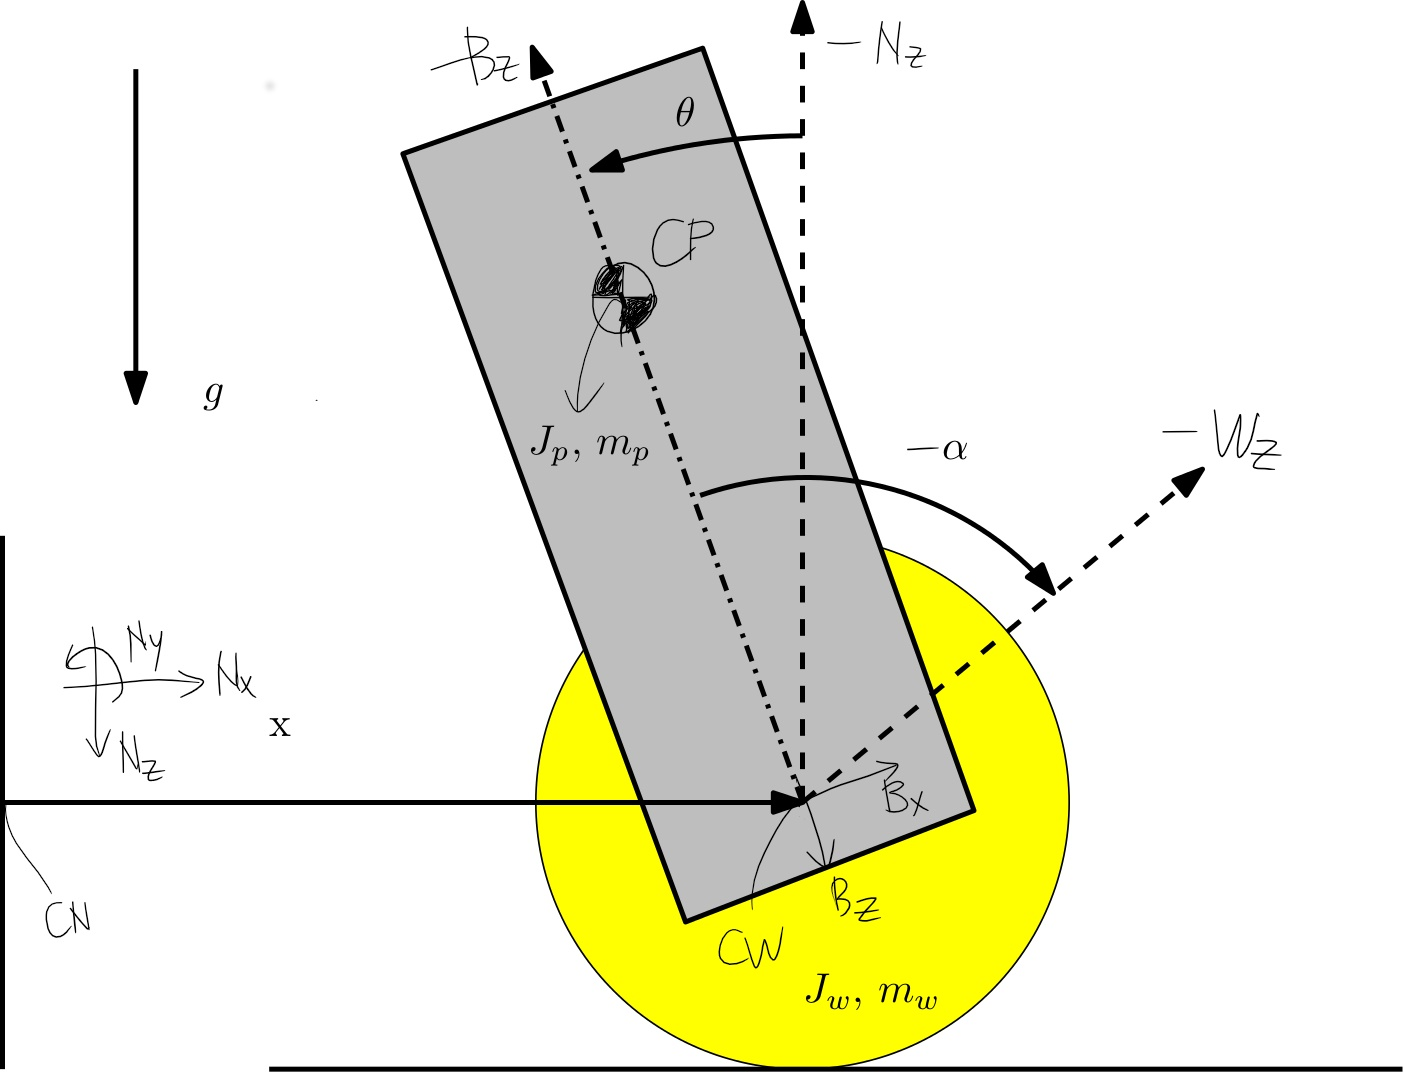

In [2]:
from IPython.display import Image
Image('figure/segway-frames_Inked.jpg', width=500)

In [1]:
from sympy import symbols, factor
from sympy import simplify
from sympy.physics.mechanics import *
from sympy import sin, cos, symbols, Matrix, solve
from sympy.physics.vector import init_vprinting
init_vprinting()

In [2]:
# Define Symbolic Variables
x, alpha, theta = dynamicsymbols('x alpha theta')
V = dynamicsymbols('V')
F,T = symbols('F,T')
m_w, m_p = symbols('m_w, m_p')
J_p, J_w = symbols('I_p, J_w')
n,k_emf,b_damp,J_motor = symbols('n,k_emf,b_damp,J_motor')
r, l = symbols('r, l')
t, g = symbols('t, g')

In [3]:
# Define Reference Frames
N = ReferenceFrame('N') #inertial frame
B = N.orientnew('B', 'Axis', [theta, N.y])  #fixed in pendulumsympy.physics.mechanics

In [4]:
# Define Points of Interest
CN = Point('CN') 
CN.set_vel(N, 0) #point CN is inertially fixed

CW = CN.locatenew('CW', x*N.x)  #wheel c.m.
CW.set_vel(B, 0) #point CW is fixed in pendulum frame, too
CW.set_vel(N, CW.pos_from(CN).diff(t, N))

CP = CW.locatenew('CP', B.z*(-l)) #pendulum c.m.
CP.set_vel(B, 0)
CP.v2pt_theory(CW, N, B);

In [5]:
# Define Bodies
# Wheel Creation
J_wheel = inertia(W, 0, J_w, 0)
wheel = RigidBody('wheel', CW, W, m_w, (J_wheel, CW))

# Pendulum Creation
J_pen = inertia(B, 0, J_p, 0)
pend = RigidBody('pend', CP, B, m_p, (J_pen, CP)) #change inertia point to point_p

NameError: name 'W' is not defined

In [6]:
nonslip_const = {alpha.diff():x.diff()/r-theta.diff()}

In [7]:
# Lagranges Method
flist = [(CP, m_p*g*N.z), (CW, F*N.x)] #force list, external torque T, damping b in y direction
L = Lagrangian(N, wheel, pend)
L_md = msubs(L, nonslip_const)
Le = LagrangesMethod(L_md, [x, theta], forcelist = flist,frame = N)
eoms = Le.form_lagranges_equations()
simplify(eoms)

⎡     2⋅J_w⋅θ̈   J_w⋅ẍ                2                               ⎤
⎢-F - ─────── + ───── + l⋅mₚ⋅sin(θ)⋅θ̇  - l⋅mₚ⋅cos(θ)⋅θ̈ + mₚ⋅ẍ + m_w⋅ẍ⎥
⎢        r         2                                                 ⎥
⎢                 r                                                  ⎥
⎢                                                                    ⎥
⎢                  2⋅J_w⋅ẍ                    2                      ⎥
⎢ Iₚ⋅θ̈ + 4⋅J_w⋅θ̈ - ─────── - g⋅l⋅mₚ⋅sin(θ) + l ⋅mₚ⋅θ̈ - l⋅mₚ⋅cos(θ)⋅ẍ ⎥
⎣                     r                                              ⎦

In [8]:
# Motor Dynamics
eom_motor = T + k_emf*V - b_damp*n*alpha.diff() - J_motor*n*alpha.diff(t,2)
eom_motor

In [9]:
# Motor Dynamics
eom_wheel = T - F*r - J_w*(-alpha.diff(t,2) + theta.diff(t,2))
T_eq = solve(eom_wheel, T)
T_eq

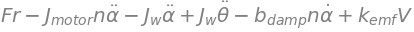

In [10]:
# combined dynamic eq
dyn_wheel_motor = msubs(eom_motor, {T:T_eq[0]})
dyn_wheel_motor

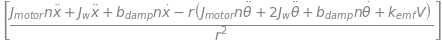

In [11]:
nonslip_const = {alpha.diff():x.diff()/r-theta.diff(), alpha.diff(t,2):x.diff(t,2)/r-theta.diff(t,2)}
res = msubs(dyn_wheel_motor, nonslip_const)
F_eq = solve(res, F)
F_eq

In [12]:
eom_dyn = msubs(eoms, {F:F_eq[0]})
simplify(eom_dyn)

⎡Jₘₒₜₒᵣ⋅n⋅θ̈   Jₘₒₜₒᵣ⋅n⋅ẍ   b_damp⋅n⋅θ̇   b_damp⋅n⋅ẋ   k_emf⋅V              
⎢────────── - ────────── + ────────── - ────────── + ─────── + l⋅mₚ⋅sin(θ)⋅θ̇ 
⎢    r             2           r             2          r                     
⎢                 r                         r                                 
⎢                                                                             
⎢                                     2⋅J_w⋅ẍ                    2           
⎢                    Iₚ⋅θ̈ + 4⋅J_w⋅θ̈ - ─────── - g⋅l⋅mₚ⋅sin(θ) + l ⋅mₚ⋅θ̈ - l
⎣                                        r                                    

  2                               ⎤
 - l⋅mₚ⋅cos(θ)⋅θ̈ + mₚ⋅ẍ + m_w⋅ẍ⎥
                              ⎥
                              ⎥
                              ⎥
                               ⎥
⋅mₚ⋅cos(θ)⋅ẍ                     ⎥
                              ⎦

In [14]:
from EoM import *

In [15]:
# Generalized coordinates
q = Matrix([[x], [theta]])
qd = q.diff()
qdd = qd.diff()

# Control Input Variable
u = Matrix([V])

# M(q)*qdd + C(q,qd) + G(q) = W*u
M, C, G, W = get_EoM_from_T(eom_dyn,qdd,g,u)
M, C, G, W

⎛⎡  Jₘₒₜₒᵣ⋅n             Jₘₒₜₒᵣ⋅n              ⎤                              
⎜⎢- ──────── + mₚ + m_w  ──────── - l⋅mₚ⋅cos(θ)⎥  ⎡b_damp⋅n⋅θ̇   b_damp⋅n⋅ẋ  
⎜⎢      2                   r                  ⎥  ⎢────────── - ────────── + l
⎜⎢     r                                       ⎥  ⎢    r             2        
⎜⎢                                             ⎥, ⎢                 r         
⎜⎢  2⋅J_w                                2     ⎥  ⎢                           
⎜⎢- ───── - l⋅mₚ⋅cos(θ)    Iₚ + 4⋅J_w + l ⋅mₚ  ⎥  ⎣                   0       
⎝⎣    r                                        ⎦                              

                                           ⎞
              2⎤                             ⎟
⋅mₚ⋅sin(θ)⋅θ̇ ⎥                    ⎡-k_emf ⎤⎟
             ⎥  ⎡      0       ⎤  ⎢───────⎥⎟
             ⎥, ⎢              ⎥, ⎢   r   ⎥⎟
             ⎥  ⎣-g⋅l⋅mₚ⋅sin(θ)⎦  ⎢       ⎥⎟
             ⎦                    ⎣   0   ⎦⎟
                                           ⎠

In [17]:
# Forward Dynamics eqation
# qdd = M(q)^-1 * ( -C(q,qd) - G(q) + W*u )
M_inv = M.inv()
qdd_rhs_A = M_inv*(-C -G)
qdd_rhs_B = M_inv*W*u
qdd_rhs_A, qdd_rhs_B

⎛⎡                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                          g⋅
⎜⎢────────────────────────────────────────────────────────────────────────────
⎜⎢                     2           2                            2             
⎜⎢Iₚ⋅Jₘₒₜₒᵣ⋅n - Iₚ⋅mₚ⋅r  - Iₚ⋅m_w⋅r  + 2⋅Jₘₒₜₒᵣ⋅J_w⋅n + Jₘₒₜₒᵣ⋅l ⋅mₚ⋅n - Jₘₒₜₒ
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                           g
⎜⎢──────────────────────────────────────────────────

In [18]:
# State-space equation. 
X = q.col_join(qd)
Xd_A = qd.col_join(qdd_rhs_A)
Xd_B = qd.col_join(qdd_rhs_B)
U = u
Xd_A, Xd_B, X, U

⎛⎡                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                          g⋅
⎜⎢────────────────────────────────────────────────────────────────────────────
⎜⎢                     2           2                            2             
⎜⎢Iₚ⋅Jₘₒₜₒᵣ⋅n - Iₚ⋅mₚ⋅r  - Iₚ⋅m_w⋅r  + 2⋅Jₘₒₜₒᵣ⋅J_w⋅n + Jₘₒₜₒᵣ⋅l ⋅mₚ⋅n - Jₘₒₜₒ
⎜⎢                                                                            
⎜⎢                                                  

In [19]:
# State-space equation
A = Xd_A.jacobian(X)
B = Xd_B.jacobian(U)
C = X.jacobian(X)
D = X.jacobian(U)
A, B, C, D

⎛⎡  0                                                                         
⎜⎢                                                                            
⎜⎢  0                                                                         
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢ 0  ────────────────────────────────────────────────────────────────────────
⎜⎢                         2           2                            2         
⎜⎢    Iₚ⋅Jₘₒₜₒᵣ⋅n - Iₚ⋅mₚ⋅r  - Iₚ⋅m_w⋅r  + 2⋅Jₘₒₜₒᵣ⋅J_w⋅n + Jₘₒₜₒᵣ⋅l ⋅mₚ⋅n - J
⎜⎢                                                                            
⎜⎢                                                  

In [20]:
eq_point = {theta:0, theta.diff():0} #a dict of the equilibrium points when the segway is not moving
ss0 = [simplify(A.subs(eq_point)), simplify(B.subs(eq_point)), C, D]
ss0

⎡⎡0                                                                          0
⎢⎢                                                                            
⎢⎢0                                                                          0
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                             g⋅l⋅mₚ⋅r⋅(-Jₘₒₜ
⎢⎢0  ─────────────────────────────────────────────────────────────────────────
⎢⎢                         2           2                            2         
⎢⎢   -Iₚ⋅Jₘₒₜₒᵣ⋅n + Iₚ⋅mₚ⋅r  + Iₚ⋅m_w⋅r  - 2⋅Jₘₒₜₒᵣ⋅J_w⋅n - Jₘₒₜₒᵣ⋅l ⋅mₚ⋅n + J
⎢⎢                                                                            
⎢⎢                                                                 ⎛          
⎢⎢                                                          g⋅l⋅mₚ⋅⎝-Jₘₒₜₒᵣ⋅n 
⎢⎢0  ───────────────────────────────────────────────

In [25]:
#
import pylab as pl
import control
param = {J_w:0.2, m_w:0.1, J_motor:0.001, J_p:2, b_damp:0, k_emf:1, g:9.8, l:1, r:0.1, m_p:1, n:1}
sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
mprint(sys0)

A = [[ 0.          0.          1.          0.        ]
     [ 0.          0.          0.          1.        ]
     [ 0.         -8.43652174  0.          0.        ]
     [ 0.         -8.52173913  0.          0.        ]]

B = [[ 0.        ]
     [ 0.        ]
     [33.04347826]
     [43.47826087]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]
     [0.]]



In [22]:
msubs(ss0[0], param)

⎡0          0          1  0⎤
⎢                          ⎥
⎢0          0          0  1⎥
⎢                          ⎥
⎢0  -8.43652173913044  0  0⎥
⎢                          ⎥
⎣0  -8.52173913043478  0  0⎦

In [23]:
# select output variable as p_dot
sys0_output = sys0[2,0]
mprint(sys0_output)

A = [[ 0.          0.          1.          0.        ]
     [ 0.          0.          0.          1.        ]
     [ 0.         -8.43652174  0.          0.        ]
     [ 0.         -8.52173913  0.          0.        ]]

B = [[ 0.        ]
     [ 0.        ]
     [33.04347826]
     [43.47826087]]

C = [[0. 0. 1. 0.]]

D = [[0.]]

